In [1]:
import numpy as np
import pandas as pd

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary
import matplotlib.pyplot as plt

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
n_per_class = 1000
img_size = 91

x = np.linspace(-4,4,img_size)
X, Y = np.meshgrid(x,x)

widths = np.linspace(2,20,n_per_class)

images = torch.zeros(n_per_class,1,img_size,img_size)

for i in range(n_per_class):
    ro = 1.5*np.random.randn(2)
    G = np.exp(- ( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i])
    
    G = G + np.random.randn(img_size, img_size)/5
    
    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,6))
    if np.random.randn()>0:
        G[i1:i1+i2,:] = 1
    else:
        G[:,i1:i1+i2] = 1
    
    images[i,:,:,:] = torch.Tensor(G).view(1, img_size, img_size)

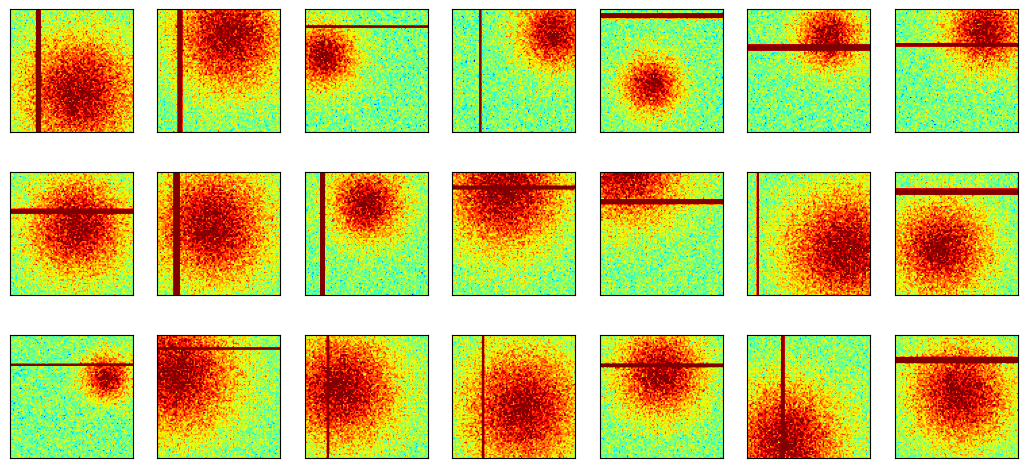

In [14]:
fig, axs = plt.subplots(3,7,figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_per_class)
    G = np.squeeze(images[which_pic, :,:])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [15]:
def create_model():
    class GausNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
            )
            
        def forward(self, x):
            return self.dec(self.enc(x))
        
    model = GausNet()
    
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    
    return model, lossfun, optimizer

 
torch.Size([10, 1, 91, 91])


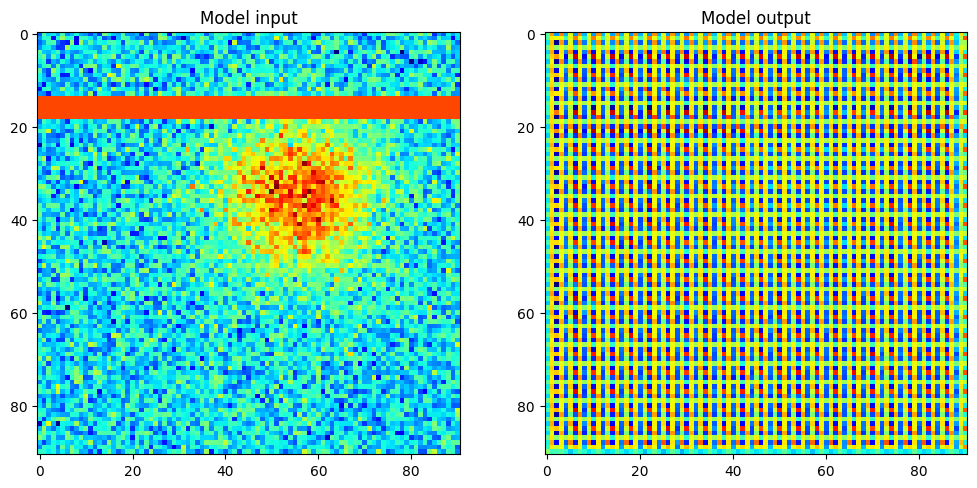

In [16]:
model, loss_func, optimizer = create_model()
yHat = model(images[:10, :,:,:])
print(' ')
print(yHat.shape)

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(), cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(), cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [18]:
summary(model, (1, img_size, img_size), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

In [21]:
num_of_epochs = 500
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    
    for epoch in range(num_of_epochs):
        model.train()
        
        pics_to_use = np.random.choice(n_per_class, size=32, replace=False)
        X = images[pics_to_use, :, :, :]

        yHat = model(X) 
        loss = loss_func(yHat, X)
        losses[epoch] = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        
    return losses, model

In [22]:
losses, model = train_model()

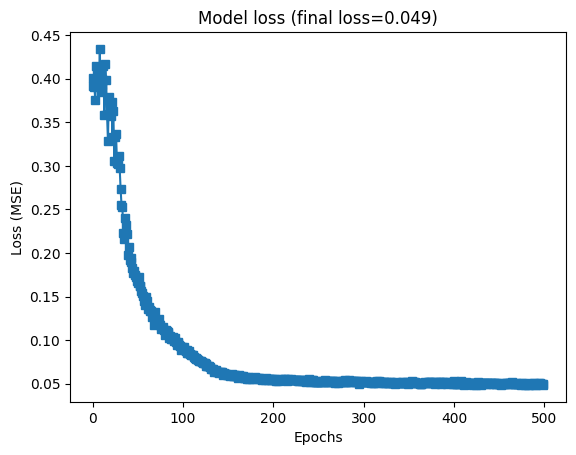

In [23]:
plt.plot(losses, 's-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss (final loss={losses[-1]:.3f})')

plt.show()

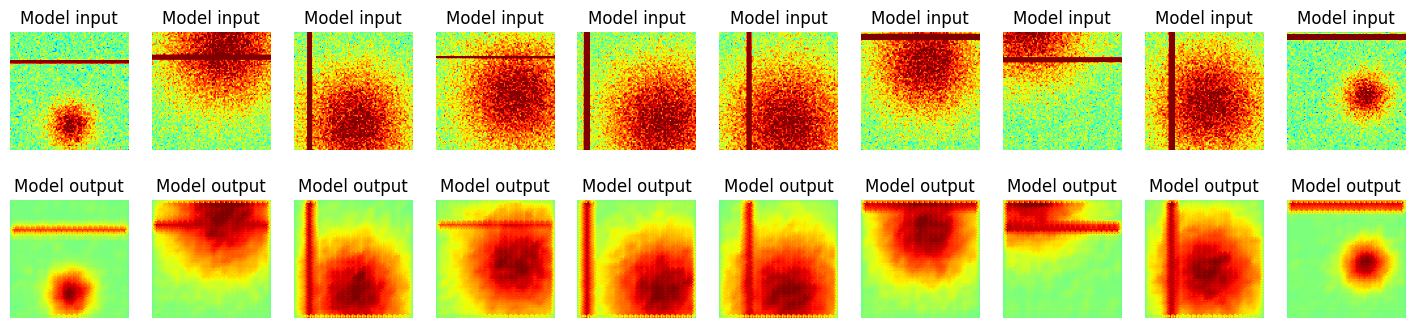

In [24]:
pics_to_use = np.random.choice(n_per_class, size=32, replace=False) 
X = images[pics_to_use, :, :, :]
yHat = model(X)

fig, axs = plt.subplots(2, 10, figsize=(18,4))

for i in range(10):
    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i, 0, :, :]).detach()
    
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model input')
    
    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model output')
    
plt.show()